# 4. Semantic Space Construction

In this notebook, the semantic space is constructed by which nouns in the Hebrew Bible can be compared for similarity. The steps are:

1) Gather data in the Hebrew Bible for all nouns in narrative clauses that function either as a subject, object, or coordinate noun within a subj/obj phrase. Another restriction is applied that requires the noun have a minimum occurrence frequency. For every noun that meets these requirements, record the verb or noun that it collocates with. Also record the target noun's role and the collocated word's role. E.g. "Subject -> verb" or "Subject -> coordinate.noun." In addition, for every verb the stem is also recorded. An example of a full tag is: "Subj -> HLK[.qal" (הלך in the qal). 

2) Apply frequency adjustments to all of the cooccurrence counts. Since different words in a text occur with many different frequencies, statistical adjustments are commonly used in semantic space constructions. This notebook experiments with the [log-likelihood](http://aclweb.org/anthology/J93-1003) and [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information#Applications) scores. 

3) Apply [principle component analysis](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/) (PCA) to compress all of the data points (cooccurrence counts) for each word into two, representative values. These values present the most informative "angle" from which to view the word cooccurrence data, i.e. the "angle" which presents the greatest amount of variation. PCA allows us to plot the words on a graph and visually inspect any potential clusters.

4) Apply similarity measures and clustering algorithms to group nouns together. Similarity measures are algorithms which compare the data for all nouns with each other to determine a distance. In other words, it calculates how similar the terms are to each other. A [clustering algorithm](https://en.wikipedia.org/wiki/Cluster_analysis) can use these distances to group the nouns into different clusters. A silhouette diagram can be used for partioning cluster methods to determine the ideal number of clusters (`k`). 

The results in this notebook are exploratory and rough. There are a few points of improvement that are needed going forward. For step 1, a more sophisiticated system of context selection must be designed. The system should not only consider predicate/object/subject/coordinate relations, but also complements and other descriptors (e.g. constructs, adjectives, adverbs, etc.). In [Padó and Lapata 2007](https://www.mitpressjournals.org/doi/pdf/10.1162/coli.2007.33.2.161), the inspiration for this experiment, a variety of paths and relationships are considered using a dependency tree. Dependency trees describe the precise relationships between words within a clause. For instance, a clause's verb is in a relation with its object; descriptors such as adjectives are in dependent relations with their described nouns, etc.. The ETCBC data does not contain such fine-grained encodings. But there is an ETCBC [tree module](https://github.com/ETCBC/lingo) (Dirk Roorda) which contains constituency trees in [Penn Treebank](https://en.wikipedia.org/wiki/Treebank) format. These trees may be useful for approximating the Padó and Lapata method. 

## Load Functions

In [3]:
import collections, os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import pairwise_distances
os.sys.path.append('../')
from project_code.phase1 import SemSpace
from project_code.kmedoids.kmedoids import kMedoids

# Build Semantic Space

Import SemSpace, the class which contains the code for all of the experiments. This class is also easily maneuverable for alternate experiment parameters.

In [4]:
semspace = SemSpace()

# give report on space size
print('Size of the space:')
for name, count in zip(('cooccurrences', 'target words'), semspace.raw.shape):
    print('\t', count, name)

**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS} feature documentation">Feature docs</a> <a target="_blank" href="https://github.com/Dans-labs/text-fabric/wiki/Bhsa" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://github.com/Dans-labs/text-fabric/wiki/api" title="text-fabric-api">Text-Fabric API</a>


This notebook online:
<a target="_blank" href="http://nbviewer.jupyter.org/github/semantics/phase1/blob/master/4. Semantic Space Construction.ipynb">NBViewer</a>
<a target="_blank" href="https://github.com/semantics/phase1/blob/master/4. Semantic Space Construction.ipynb">GitHub</a>


Size of the space:
	 1158 cooccurrences
	 230 target words


### Import BHSA Helpers & Text-Fabric

In [5]:
get_lex = semspace.get_lex # returns a lex node
tf_api = semspace.tf_api
B = semspace.B
F, E, L, T = tf_api.F, tf_api.E, tf_api.L, tf_api.T

### Raw and Adjusted Frequency Matrices

In [6]:
# Adjusted Counts (and raw counts)
cooccurrences = semspace.raw
test_ll = semspace.loglikelihood
test_pmi = semspace.pmi

# give e.g.
test_ll.head(5)

,<BD/,<BDH/,<DH/,<DWT/,<GL/,<GLH=/,<JN/,<JR/,<LH/,<M/,...,XYJ/,XYR/,Y>N/,YDQH/,YWM/,ZBX/,ZHB/,ZJT/,ZQN/,ZR</
Objc.<BD[.hif,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.613601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Objc.<BD[.qal,0.0,23.310705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Objc.<BR[.hif,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Objc.<BR[.qal,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Objc.<DH[.qal,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,5.821454,0.0,0.0,0.0


### Top Counts

Examine the top counts to see how the frequency adjustments affect the overal values.

**Top Raw Counts**

In [7]:
cooccurrences.sum().sort_values(ascending=False).head(5)

BN/     524.0
MLK/    474.0
<M/     347.0
>JC/    310.0
DBR/    202.0
dtype: float64

**Top Log-likelihood**

In [8]:
test_ll.sum().sort_values(ascending=False).head(5)

BN/     1135.979442
MLK/    1095.477110
DBR/     846.523688
CM/      828.045734
<M/      806.088620
dtype: float64

**Top PMI counts**

In [9]:
test_pmi.sum().sort_values(ascending=False).head(5)

<M/     1249.705924
BN/     1209.143338
MLK/     881.533047
>JC/     868.768996
BJT/     607.060336
dtype: float64

## Vector Space Construction with PCA

Use Principal Component Analysis (PCA) to look at the data.

### PCA Assignments from SemSpace

In [13]:
pca_raw = semspace.pca_raw
pca_ll = semspace.pca_ll
pca_pmi = semspace.pca_pmi

In [16]:
def annotate(matrix):
    'Annotates PCA plots with word lexemes'
    words = [F.gloss.v(get_lex(l)) for l in cooccurrences.columns]
    for i, word in enumerate(words):
        plt.annotate(word, xy=(matrix[i, 0], matrix[i, 1]))

### PCA with Raw Counts

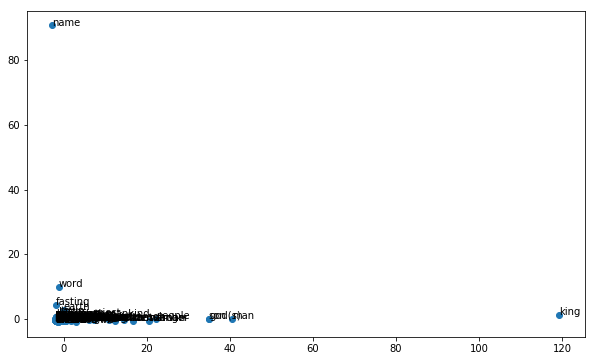

In [17]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])
annotate(pca_raw)

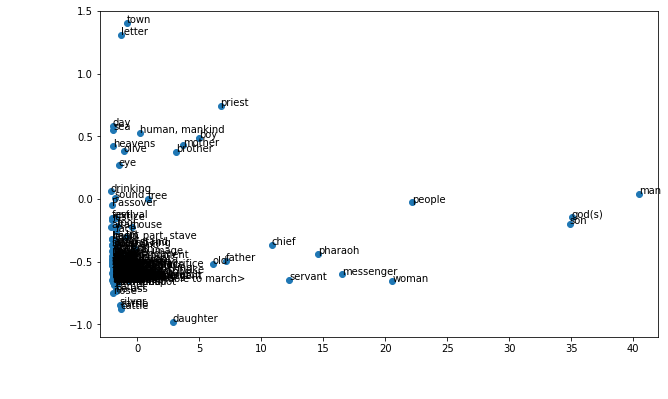

In [18]:
# Closer view of the raw counts PCA
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])
plt.axis([-3, 42, -1.1, 1.5])
annotate(pca_raw)

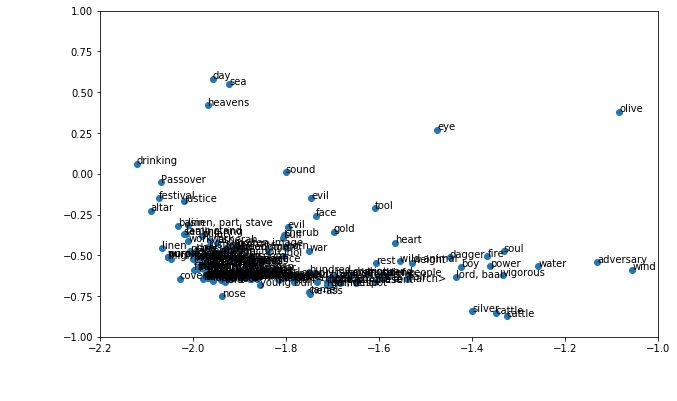

In [19]:
# Closer view of the raw counts PCA
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])
plt.axis([-2.2, -1, -1, 1])
annotate(pca_raw)

[-2.07, -1.8, -0.75, -0.25]

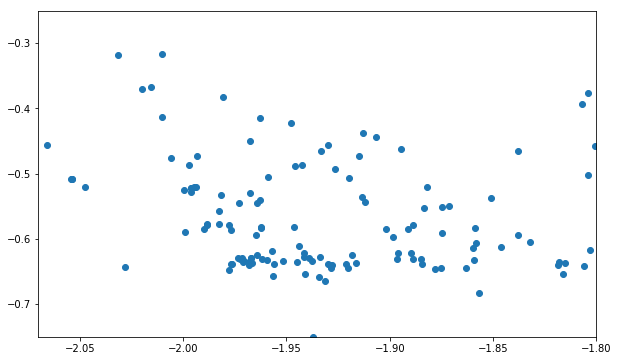

In [20]:
# Closer view of the raw counts PCA
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])
plt.axis([-2.07, -1.8, -0.75, -0.25])
#annotate(pca_raw)

There seems to be some interesting clumps between y-0.6 and y-0.7. Let's look closer...

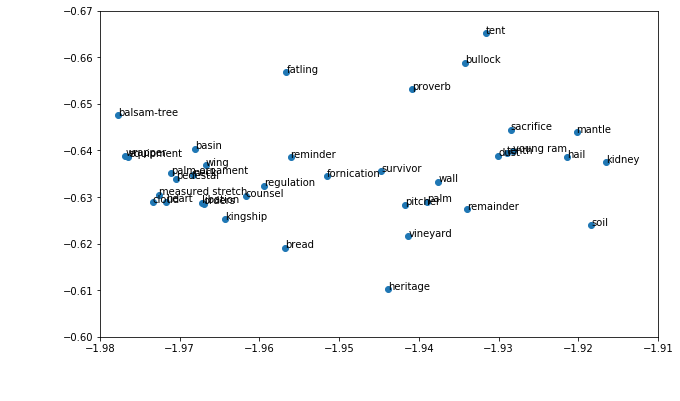

In [21]:
# Closer view of the raw counts PCA
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])
plt.axis([-1.98, -1.91, -0.6, -0.67])
annotate(pca_raw)

There is a lot of diversity still reflected here. Although, there are some interesting cases. For instance, "regulation," "counsel," and "reminder" are fairly close to one another. These could be interesting to isolate and examine later on.

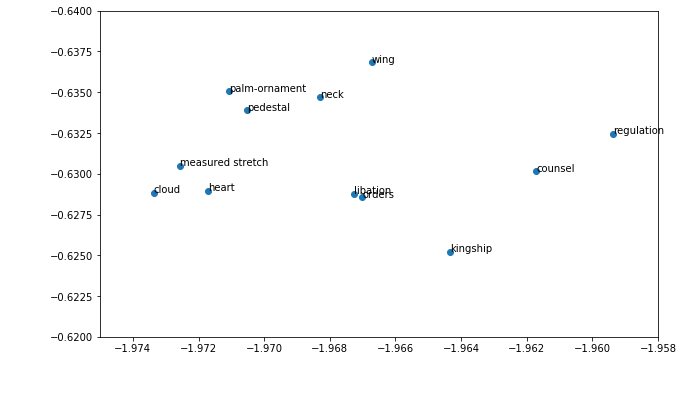

In [22]:
# Closer view of the raw counts PCA
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])
plt.axis([-1.975, -1.958, -0.62, -0.64])
annotate(pca_raw)

### Normalized with Ratio

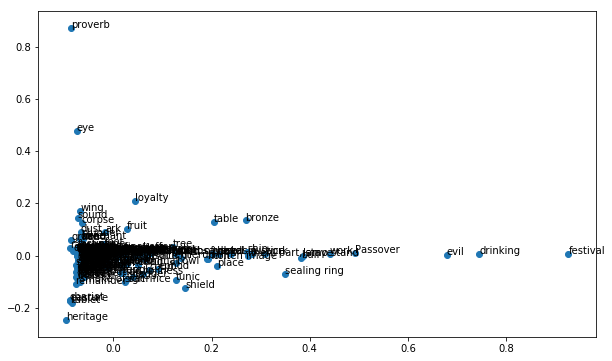

In [23]:
ratio_raw = cooccurrences.apply(lambda col: col.values / col.sum())
ratio_pca = semspace.apply_pca(ratio_raw)
plt.figure(1, figsize=(10, 6))
plt.scatter(ratio_pca[:, 0], ratio_pca[:, 1])
annotate(ratio_pca)

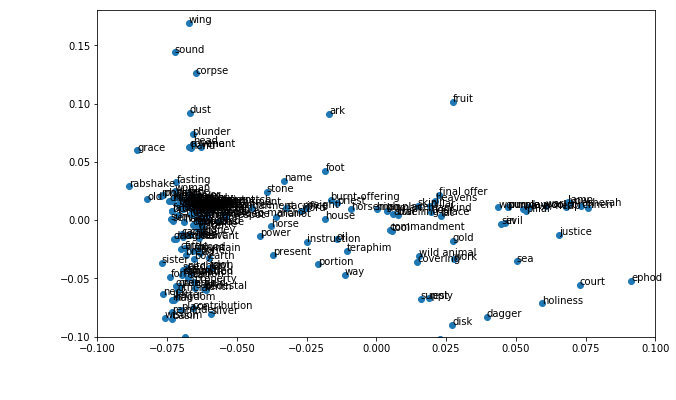

In [24]:
# Closer view of the raw counts PCA
plt.figure(1, figsize=(10, 6))
plt.scatter(ratio_pca[:, 0], ratio_pca[:, 1])
plt.axis([-0.1, 0.1, -0.1, 0.18])
annotate(ratio_pca)

### PCA with Log-likelihood (G test)

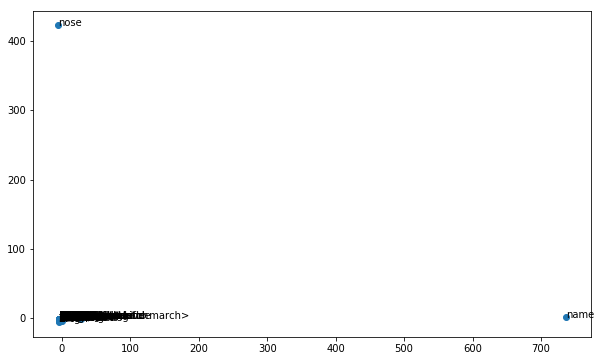

In [25]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])
annotate(pca_ll)
plt.savefig('images/ll_space.png')

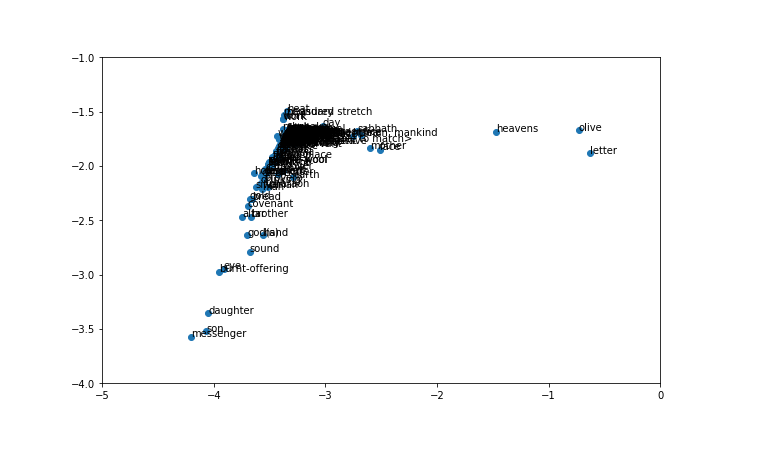

In [26]:
# closer view of LL
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])
plt.axis([-5, 0, -4, -1])
annotate(pca_ll)
plt.savefig('images/ll_space_zoom.png')

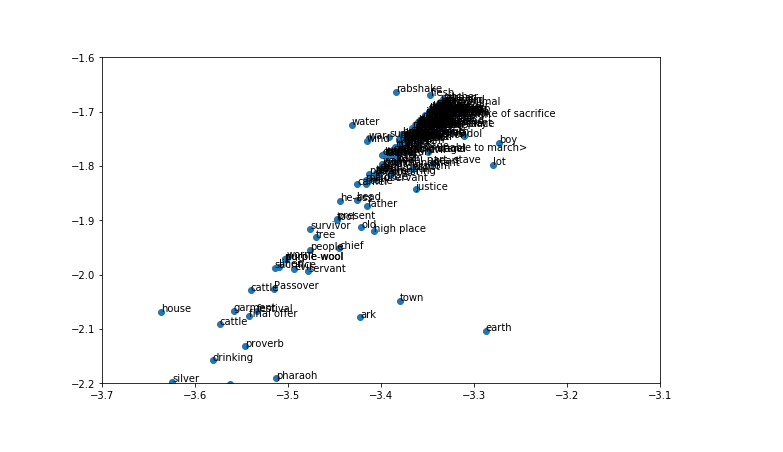

In [27]:
# closer view of LL
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])
plt.axis([-3.7, -3.1, -2.2, -1.6])
annotate(pca_ll)
plt.savefig('images/ll_space_zoom2.png')

#### LL, 3D Plot

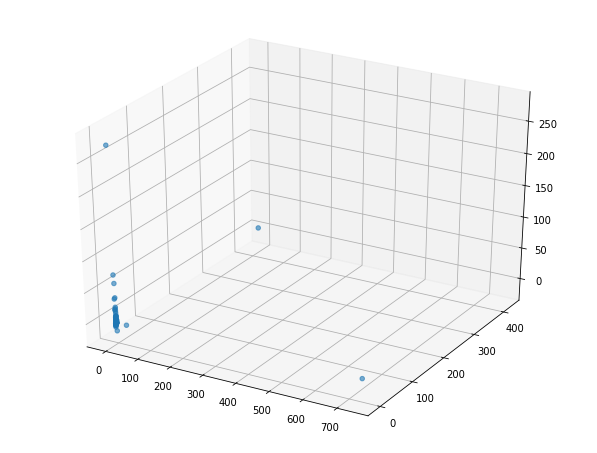

In [28]:
pca_ll_3D = semspace.pca_ll_3d

x = pca_ll_3D[:, 0]
y = pca_ll_3D[:, 1]
z = pca_ll_3D[:, 2]
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(x, y, z, marker='o', alpha=0.6)
plt.show()

### PCA with Pointwise Mutual Information

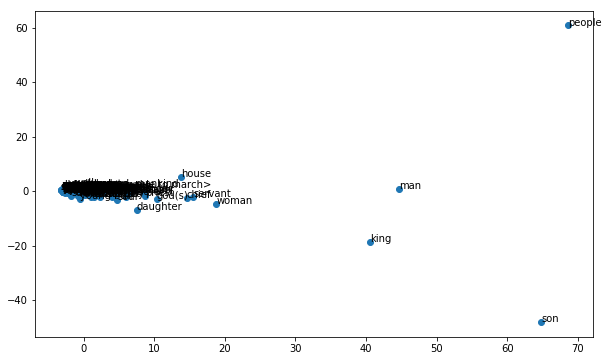

In [29]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])
annotate(pca_pmi)

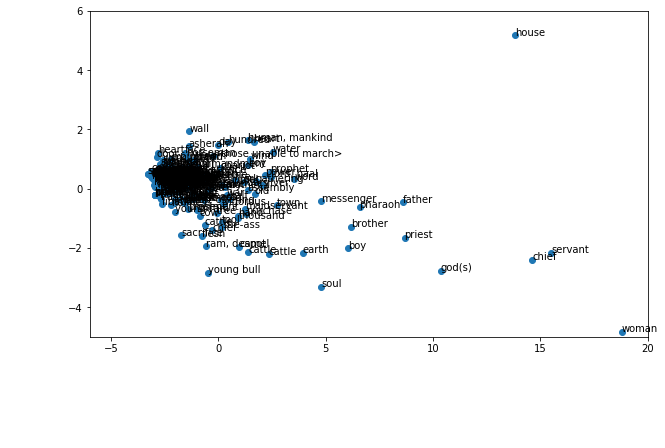

In [30]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])
plt.axis([-6, 20, -5, 6])
annotate(pca_pmi)

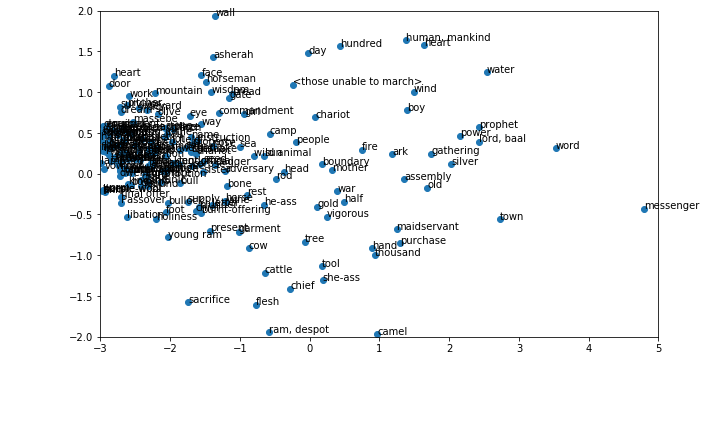

In [31]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])
plt.axis([-3, 5, -2, 2])
annotate(pca_pmi)

In this plot, one can see a tendency for "person" nouns to lie further to the right of the X-axis. Additionally, livestock nouns appear to be loosely clustered together. 

### Conclusions

The PCA transformation has allowed us to create a series of plots demonstrating what the data looks like under different transformation methods. What is not clear, though, is how to interpret and utilize these results. The PMI association measure with PCA transformation shows a better spread of the data

## Distances and Similarities

Use cosine similarity to construct a similarity matrix. Export a set of similarity sets.

In [32]:
row_col = [F.lex.v(get_lex(w)) + ' (' + F.gloss.v(get_lex(w)) + ')' for w in cooccurrences.columns]

# distances, non-pca
ll_dists = pairwise_distances(test_ll.T.values, metric='cosine')
pmi_dists = pairwise_distances(test_pmi.T.values, metric='cosine')
raw_dists = pairwise_distances(cooccurrences.T.values, metric='cosine')

# distances, pca
pca_dists_ll = pairwise_distances(pca_ll, metric='euclidean')
pca_dists_pmi = pairwise_distances(pca_pmi, metric='euclidean')
pca_dists_raw = pairwise_distances(pca_raw, metric='euclidean')

# distance matrices
ll_dist_matrix = pd.DataFrame(ll_dists, columns=row_col, index=row_col)
pmi_dist_matrix = pd.DataFrame(pmi_dists, columns=row_col, index=row_col)
raw_dist_matrix = pd.DataFrame(raw_dists, columns=row_col, index=row_col)
pca_ll_dist_matrix = pd.DataFrame(pca_dists_ll, columns=row_col, index=row_col)
pca_pmi_dist_matrix = pd.DataFrame(pca_dists_pmi, columns=row_col, index=row_col)
pca_raw_dist_matrix = pd.DataFrame(pca_dists_raw, columns=row_col, index=row_col)

# similarity matrices
ll_sim_matrix = ll_dist_matrix.apply(lambda x: 1-x)
pmi_sim_matrix = pmi_dist_matrix.apply(lambda x: 1-x)
raw_sim_matrix = raw_dist_matrix.apply(lambda x: 1-x)

# jaccard distance - experiment
jacc_dist_pair = pairwise_distances((cooccurrences > 0).T.values, metric='jaccard')
jacc_dist = pd.DataFrame(jacc_dist_pair, columns=row_col, index=row_col)
jacc_sim = jacc_dist.apply(lambda x: 1-x)

# ratio-raw distance - experiment
ratio_raw_pair = pairwise_distances(ratio_raw.T.values, metric='cosine')
ratio_raw_dist = pd.DataFrame(ratio_raw_pair, columns=row_col, index=row_col)

In [22]:
pca_ll_dist_matrix['CMJM/ (heavens)'].sort_values()[1:].head()

ZJT/ (olive)     0.741253
SPR/ (letter)    0.863495
PNH/ (face)      1.054471
>M/ (mother)     1.136221
JM/ (sea)        1.208986
Name: CMJM/ (heavens), dtype: float64

### Export Word Similarity Lists to data/{method} directories

In [23]:
for method, matrix in (('ll', ll_sim_matrix), 
                       ('pmi', pmi_sim_matrix), 
                      ):
        
    for noun in matrix.index:
        
        data_dir = f'data/{method}'
        
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)
                
        name = noun.replace('/', '').replace('\\', '')
        word_path = os.path.join(data_dir, f'{name}.csv')
        matrix[noun].sort_values(ascending=False).to_csv(word_path)

print('done!')

done!


In [234]:
for method, matrix in (('ll_pca', pca_ll_dist_matrix), 
                       ('pmi_pca', pca_pmi_dist_matrix), 
                       ('raw_pca', pca_raw_dist_matrix), 
                      ):
        
    for noun in matrix.index:
        
        data_dir = f'data/{method}'
        
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)
                
        name = noun.replace('/', '').replace('\\', '')
        word_path = os.path.join(data_dir, f'{name}.csv')
        matrix[noun].sort_values().to_csv(word_path)

print('done!')

done!


#### Jaccardian Distance Test

How about word similarities based on jaccardian distance?

In [25]:
for method, matrix in (('jaccard_similarity', jacc_sim), 
                      ):
        
    for noun in matrix.index:
        
        data_dir = f'data/{method}'
        
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)
                
        name = noun.replace('/', '').replace('\\', '')
        word_path = os.path.join(data_dir, f'{name}.csv')
        matrix[noun].sort_values(ascending=False).to_csv(word_path)

print('done!')

done!


#### Examine Jaccardian Distances

I'm interested in cases where nouns have the same slots filled, but which are unexpectedly so. 

## Cluster Tests

### With Jaccardian Distance

In [26]:
medoids, clusters = kMedoids(jacc_dist_pair, 2, state=1)

In [27]:
def show_clusters(clusters):
    for clust, indexes in clusters.items():
        print(clust)
        for i in indexes:
            word = cooccurrences.columns[i]
            gloss = F.gloss.v(semspace.get_lex(word))
            print(gloss, end=' | ')
        print()
        print()
        
show_clusters(clusters)

0
work | reminder | bull | eye | pillar | cloud | dust | neck | skin | counsel | bone | father | fire | woman | asherah | soil | pedestal | tent | ram, despot | pillar | porch | mother | ship | nose | ephod | purple-wool | lion | she-ass | spirit of dead | supply | brother | balsam-tree | garment | cattle | high place | son | cattle | hail | covenant | daughter | gate | sabbath | linen | plunder | final offer | table | heavens | oil | maidservant | bullock | orders | open field | wrapper | mantle | survivor | boundary | vigorous | wave, heap | basin | idols | camel | lot | shovel | soothsayer | wine | remainder | day | young ram | pitcher | basin | disk | tool | kidney | wing | palm | vineyard | cherub | silver | tunic | heart | bread | deed | tenth | proverb | drinking | measured stretch | shield | pasture | place | work | work | king | kingship | war | lamp stand | purchase | fatling | molten image | staff | camp | massebe | commandment | altar | bowl | prophet | corpse | equipment |

### With Ratio Raw Distances

In [28]:
medoids, clusters = kMedoids(ratio_raw_pair, 2, state=1)

show_clusters(clusters)

0
work | gathering | bull | eye | burnt-offering | pillar | cloud | skin | tree | counsel | father | asherah | human, mankind | soil | tent | pillar | porch | god(s) | mother | ship | nose | ephod | purple-wool | lion | ark | she-ass | spirit of dead | lord, baal | linen, part, stave | balsam-tree | house | high place | covenant | gate | rod | linen | plunder | final offer | table | name | sun | heavens | bullock | word | door | wrapper | survivor | adversary | boundary | vigorous | wave, heap | idols | people | shovel | soothsayer | wine | sea | day | young ram | weight | priest | basin | tool | wing | palm | vineyard | cherub | tunic | heart | deed | dwelling-place | proverb | justice | drinking | measured stretch | place | messenger | work | work | king | kingship | war | lamp stand | fatling | covering | molten image | camp | commandment | altar | bowl | boy | girl | prophet | equipment | vow | chief | lamp | libation | bronze | pharaoh | horseman | mule | fruit | Passover | holine

## Evaluating Similarities

In words that are unexpectedly similar, what kinds of factors contribute to their similarity? What kinds of verbs and relationships lead to similarity?

### Jaccardian Similarity

The Jaccardian measure of similarity is especially interesting for our analysis because it simply measures whether a given value is the same between two words or not. In my study here, I have converted raw counts into a simple binary `True` or `False` value, which the Jaccardian measure then uses to calculate the similarity between the words.

While the frequency of a context's occurrence no doubt tells us about the register or use of a word, we are most interested at this point in word attributes, and specifically, we are mainly interested in whether a given "attribute" is ever activated in the corpus or not. The Jaccardian method is helpful for this kind of analysis.

How much similarity can be obtained using this approach? We plot the maximum similarity value for all of the terms in the corpus below.

<BarContainer object of 9 artists>

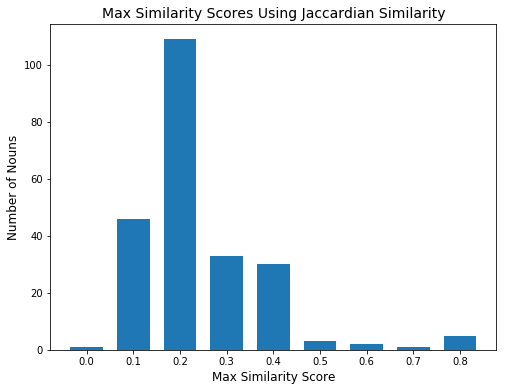

In [148]:
# count max similarities
max_sims = collections.Counter()

for word in jacc_sim.columns:
    max_sim = round(jacc_sim[word].sort_values(ascending=False)[1:].max(), 1) # index [:1] to omit words' self
    max_sims[max_sim] += 1

max_sims = sorted((value, count) for value, count in max_sims.items())

# make barplot
plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.set_xticks([v[0] for v in max_sims])
ax.set_xlabel('Max Similarity Score', size=12)
ax.set_ylabel('Number of Nouns', size=12)
plt.title('Max Similarity Scores Using Jaccardian Similarity', size=14)
plt.bar([v[0] for v in max_sims], [v[1] for v in max_sims], 
        width=0.07,
       )

**plotted in a histogram**

(array([ 2., 25., 23., 12.,  8.,  4.,  1.,  1.,  1.,  2.]),
 array([0.008, 0.085, 0.162, 0.239, 0.316, 0.393, 0.47 , 0.547, 0.624,
        0.701, 0.778]),
 <a list of 10 Patch objects>)

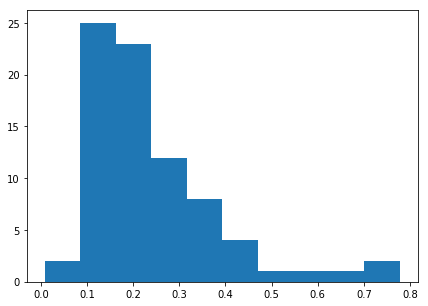

In [159]:
# count max similarities
max_sims = collections.Counter()

for word in jacc_sim.columns:
    max_sim = round(jacc_sim[word].sort_values(ascending=False)[1:].max(), 3) # index [:1] to omit words' self
    max_sims[max_sim] += 1

max_sims = sorted((value, count) for value, count in max_sims.items())

plt.figure(figsize=(7, 5))
plt.hist([v[0] for v in max_sims])

### PMI with Cosine Similarity

<BarContainer object of 10 artists>

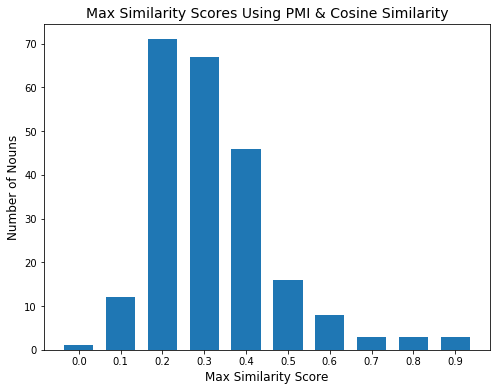

In [160]:
# count max similarities
max_sims = collections.Counter()

for word in pmi_sim_matrix.columns:
    max_sim = round(pmi_sim_matrix[word].sort_values(ascending=False)[1:].max(), 1) # index [:1] to omit words' self
    max_sims[max_sim] += 1

max_sims = sorted((value, count) for value, count in max_sims.items())

# make barplot
plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.set_xticks([v[0] for v in max_sims])
ax.set_xlabel('Max Similarity Score', size=12)
ax.set_ylabel('Number of Nouns', size=12)
plt.title('Max Similarity Scores Using PMI & Cosine Similarity', size=14)
plt.bar([v[0] for v in max_sims], [v[1] for v in max_sims], 
        width=0.07,
       )

### Digging Into Jaccardian Results

I see that there is a significant drop in the number of results at 0.3 maximum similarity. Let's see what words those entail.

In [164]:
high_score = [word.split()[1].replace(')', '').replace('(', '') for word in jacc_sim.columns 
                     if jacc_sim[word][jacc_sim[word] >= 0.3].shape[0] > 1]

' | '.join(high_score)

'reminder | bull | skin | pillar | porch | ephod | purple-wool | she-ass | spirit | sign | supply | balsam-tree | cattle | cattle | linen | sun | maidservant | idol | wrapper | adversary | idols | camel | soothsayer | young | vineyard | silver | tunic | tenth | justice | lamp | purchase | molten | commandment | equipment | lamp | libation | young | mule | holiness | horn | purple | teraphim | contribution | worm | instruction | he-ass | portion | regulation | dagger | sin | cattle | gold | olive'

It seems likely that many of these results might be nouns which I have seen in biblical lists.

In [165]:
# for hs in high_score:
#     print(jacc_sim[hs].sort_values(ascending=False).head(10))
#     print()

### Case Study: Similarities between "water" and "hand"

Water and hand are rated as 12% similar by the Jaccard method. Where does this similarity come from?

In [66]:
water = 'MJM/'
water = cooccurrences[water][cooccurrences[water] > 0].sort_values(ascending=False)

In [67]:
hand = 'JD/'
hand = cooccurrences[hand][cooccurrences[hand] > 0].sort_values(ascending=False)

The observed common contexts between water and hand are as follows:

In [68]:
hand_water_sim = list(i for i in water.index if i in hand.index)

hand_water_sim

['Objc.NTN[.qal',
 'Subj.CWB[.qal',
 'Objc.ML>[.piel',
 'Objc.HPK[.qal',
 'Objc.NYB[.hif',
 'Objc.CWB[.hif',
 'Objc.R>H[.qal',
 'Subj.JBC[.qal',
 'Subj.HLK[.qal',
 'Objc.BW>[.hif']

Both hand and water "walk/go" הלך. They share the attribute of movement.

In [50]:
hand_goes = '''

clause
    phrase function=Subj
        word lex=JD/
    phrase function=Pred
        word lex=HLK[
'''

hand_goes = sorted(B.search(hand_goes))

B.show(hand_goes)


## Result 0
(**clause** `451550`, **phrase** `724384`, **word** `129940`, **phrase** `724383`, **word** `129939`)


How does a hand "fill"?

In [51]:
hand_fills = '''

clause
    phrase function=Subj
        word lex=JD/
    phrase function=Pred
        word lex=ML>[
'''

hand_fills = sorted(B.search(hand_fills))

B.show(hand_fills)


## Result 0
(**clause** `468197`, **phrase** `774245`, **word** `212307`, **phrase** `774247`, **word** `212309`)


In [59]:
with_blood = L.d(L.d(T.nodeFromSection(('Isaiah', 1, 15)), 'sentence')[3], 'phrase')[1]

F.function.v(with_blood)

'Objc'

In this example, we see that a hand fills "with blood." Is that different than when water "fills" something? We would expect so. We search below.

In [69]:
water_fills = '''

clause
    phrase function=Subj
        word lex=MJM/
    phrase function=Pred
        word lex=ML>[
'''

water_fills = sorted(B.search(water_fills))

B.show(water_fills)


## Result 0
(**clause** `469318`, **phrase** `777424`, **word** `217452`, **phrase** `777425`, **word** `217454`)


Quite interesting what we find here! The verb actually functions in the same way as it does with יד, with דם functioning as a complement object. We can also note that these two examples are derived from First Isaiah.

Investigating further, water does not usually serve as the subject of this verb in Hebrew when it refers to filling something. It is usually a complement object, as seen in the query below.

In [64]:
vessel_fills = '''

clause
    phrase function=Objc
        word lex=MJM/
    phrase function=Pred
        word lex=ML>[
'''

vessel_fills = sorted(B.search(vessel_fills))

# B.show(vessel_fills) # uncomment me

What is fascinating with the example of יד and מים is that both share the attribute of being "fillable." Hands are filled with blood. The waters of Dimon are filled with blood. In both cases, the object that the hands or water is being "filled" with is another liquid, דם. 

In [36]:
water_goes = '''

clause
    phrase function=Subj
        word lex=MJM/
    phrase function=Pred
        word lex=HLK[
'''

water_goes = sorted(B.search(water_goes))

B.show(water_goes)


## Result 0
(**clause** `463892`, **phrase** `761691`, **word** `191120`, **phrase** `761690`, **word** `191118`)
